#  Les Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Librairie re pour traiter des caratères spécifiques
import re
#Librairie de netoyage de tweets
!pip install tweet-preprocessor
import preprocessor as tpr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC

# Creation du DataFrame

In [2]:
# Importation du premier dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))

In [3]:
sarc = pd.DataFrame(data)

In [4]:
# Importation du deuxieme dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))

In [5]:
sarc_2 = pd.DataFrame(data)

# Comparaison et fusion des 2 datasets

In [6]:
sarc_2['is_sarcastic'].mean()

0.476396799329117

In [7]:
sarc['is_sarcastic'].mean()

0.43895316185555433

In [8]:
# Fusion des 2 datasets et suppression des doublons
sarc = pd.concat([sarc,sarc_2])
sarc = sarc.drop_duplicates()
sarc.reset_index(drop=True,inplace=True)

In [9]:
sarc.describe(include='all')

,article_link,headline,is_sarcastic
count,28617,28617,28617.000000
unique,28617,28503,NaN
top,https://www.theonion.com/concerned-nra-officia...,"'no way to prevent this,' says only nation whe...",NaN
freq,1,12,NaN
mean,NaN,NaN,0.476395
std,NaN,NaN,0.499451
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


In [10]:
# Check des cases vides
sarc.isnull().any()

article_link    False
headline        False
is_sarcastic    False
dtype: bool

# Data Cleaning

In [11]:
# Utilisation de la librairie re pour traiter des caratères spécifiques
# Choix des caractères à effacer et à remplacer

replace_q = re.compile("(\?)")
replace_ex = re.compile("(\!)")
to_remove = re.compile("(\.)|(\;)|(\:)|(\')|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")

In [12]:
# Fonction de cleaning de la data utilisant tweet-processor et re

def cleaner(line):
    tmp_line = tpr.clean(line)
    tmp_line = replace_q.sub(" ? ",tmp_line.lower())
    tmp_line = replace_ex.sub(" ! ",tmp_line)
    tmp_line = to_remove.sub("",tmp_line)
    return tmp_line

In [13]:
# Cleaning de la data
h_clean = sarc['headline'].apply(cleaner)

# Ajout de la data clean au dataset
sarc["headline_clean"] = h_clean

In [14]:
sarc

,article_link,headline,is_sarcastic,headline_clean
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...
...,...,...,...,...
28612,https://www.theonion.com/tyson-holds-contest-t...,tyson holds contest to let fans submit new ide...,1,tyson holds contest to let fans submit new ide...
28613,https://politics.theonion.com/increasingly-coc...,increasingly cocky bernie sanders announces he...,1,increasingly cocky bernie sanders announces he...
28614,https://www.theonion.com/cash-strapped-zuckerb...,cash-strapped zuckerberg forced to sell 11 mil...,1,cash-strapped zuckerberg forced to sell millio...
28615,https://local.theonion.com/grocery-store-bar-a...,grocery store bar actually has great little ha...,1,grocery store bar actually has great little ha...


In [15]:
sarc['headline'][28589]

'stock value of billions of otherwise worthless data, photos, videos, opinions plummets'

In [16]:
sarc['headline_clean'][28589]

'stock value of billions of otherwise worthless data photos videos opinions plummets'

In [17]:
sarc['is_sarcastic'].mean()

0.4763951497361708

# Construction des sets Train et Test

In [18]:
# Construction des features et de la target
x = sarc.headline_clean.values
y = sarc.is_sarcastic.values

x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.3,
                                                   stratify=y)

# Vectorisation

In [19]:
#Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(binary=True, stop_words="english")


x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [20]:
#Vectorisation avec TfidfVectorizer
t_vectorizer = TfidfVectorizer(use_idf=True, stop_words="english")

t_vectorized = t_vectorizer.fit(x)

x_train_tfidf = t_vectorizer.transform(x_train)
x_test_tfidf = t_vectorizer.transform(x_test)

# Construction des modèles

**Regression Logistique**

In [21]:
# Regression Logistique avec CountVectorizer

cv_reg = LogisticRegression()
cv_reg.fit(x_train_vec,y_train)

LogisticRegression()

In [22]:
y_train_vec_pred = cv_reg.predict(x_train_vec)

In [23]:
y_test_vec_pred = cv_reg.predict(x_test_vec)

In [24]:
# score train
cv_reg.score(x_train_vec,y_train)


0.9517248265188957

In [25]:
# score train
cv_reg.score(x_test_vec,y_test)

0.7969951083158631

In [26]:
# Regression Logistique avec TfidfVectorizer

tv_reg = LogisticRegression()
tv_reg.fit(x_train_tfidf,y_train)

LogisticRegression()

In [27]:
# score train
tv_reg.score(x_train_tfidf,y_train)

0.9012031351405322

In [28]:
# score test
tv_reg.score(x_test_tfidf,y_test)

0.7889587700908456

    Matrices de confusion

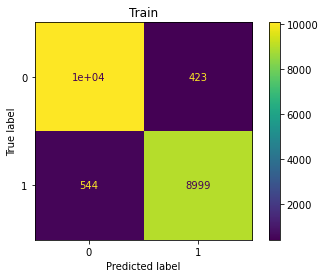

accuracy-score on train set :  0.9517248265188957
precision-score on train set :  0.9551050732328593
recall-score on train set :  0.9429948653463271
F1-score on train set :  0.9490113366728183


In [29]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_reg.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_reg.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_reg.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_reg.predict(x_train_vec)))

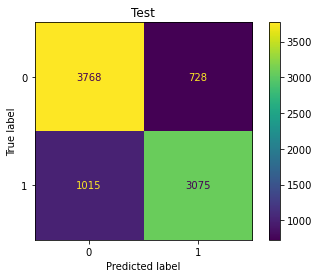

accuracy-score on test set :  0.7969951083158631
precision-score on test set :  0.8085721798580069
recall-score on test set :  0.7518337408312958
F1-score on test set :  0.7791714177118967


In [30]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_reg.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_reg.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_reg.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_reg.predict(x_test_vec)))

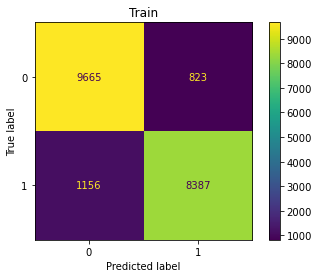

accuracy-score on train set :  0.9012031351405322
precision-score on train set :  0.9106406080347449
recall-score on train set :  0.8788640888609452
F1-score on train set :  0.8944702180984377


In [31]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_train_tfidf,y_train)
cm_tfidf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_reg.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_reg.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_reg.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_reg.predict(x_train_tfidf)))

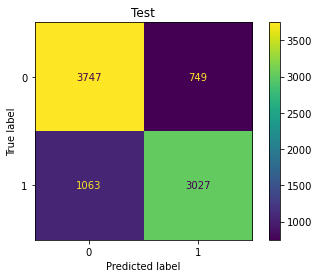

accuracy-score on test set :  0.7889587700908456
precision-score on test set :  0.8016419491525424
recall-score on test set :  0.7400977995110024
F1-score on test set :  0.7696414950419527


In [32]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_test_tfidf,y_test)
cm_tfidf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_reg.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_reg.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_reg.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_reg.predict(x_test_tfidf)))

**Random Forest**

In [33]:
# Randomforest avec CountVectorizer

cv_rf = RandomForestClassifier()
cv_rf.fit(x_train_vec,y_train)

RandomForestClassifier()

In [34]:
# score train
cv_rf.score(x_train_vec,y_train)

1.0

In [35]:
# score test
cv_rf.score(x_test_vec,y_test)

0.7558816678313534

In [36]:
# Randomforest avec TfidfVectorizer

tv_rf = RandomForestClassifier()
tv_rf.fit(x_train_tfidf,y_train)

RandomForestClassifier()

In [37]:
# score train
tv_rf.score(x_train_tfidf,y_train)

1.0

In [38]:
# score test
tv_rf.score(x_test_tfidf,y_test)

0.7638015373864431

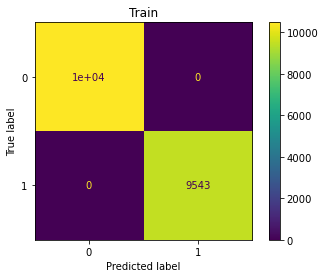

accuracy-score on train set :  1.0
precision-score on train set :  1.0
recall-score on train set :  1.0
F1-score on train set :  1.0


In [39]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_rf.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_rf.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_rf.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_rf.predict(x_train_vec)))

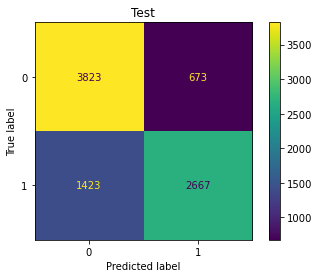

accuracy-score on test set :  0.7558816678313534
precision-score on test set :  0.798502994011976
recall-score on test set :  0.652078239608802
F1-score on test set :  0.7179004037685061


In [40]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_rf.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_rf.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_rf.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_rf.predict(x_test_vec)))

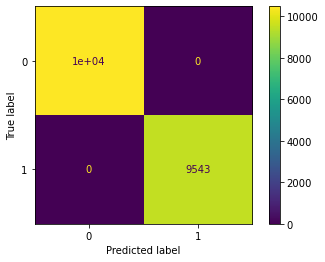

accuracy-score on train set :  1.0
precision-score on train set :  1.0
recall-score on train set :  1.0
F1-score on train set :  1.0


In [41]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_train_tfidf,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_rf.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_rf.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_rf.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_rf.predict(x_train_tfidf)))

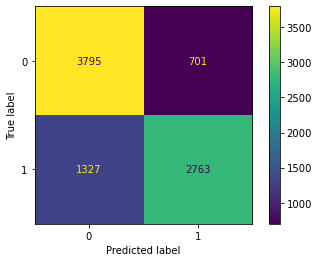

accuracy-score on test set :  0.7638015373864431
precision-score on test set :  0.7976327944572749
recall-score on test set :  0.6755501222493887
F1-score on test set :  0.7315329626687848


In [42]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_test_tfidf,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_rf.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_rf.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_rf.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_rf.predict(x_test_tfidf)))

**Support Vector Machine**

In [43]:
# SVM avec CountVectorizer

cv_svm = SVC()
cv_svm.fit(x_train_vec,y_train)

SVC()

In [44]:
# score train
cv_svm.score(x_train_vec,y_train)

0.9715940292546553

In [45]:
# score test
cv_svm.score(x_test_vec,y_test)

0.7905893314698346

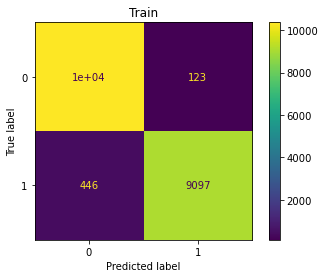

accuracy-score on train set :  0.9715940292546553
precision-score on train set :  0.9866594360086768
recall-score on train set :  0.9532641726920256
F1-score on train set :  0.9696743591110164


In [46]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_svm.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_svm.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_svm.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_svm.predict(x_train_vec)))

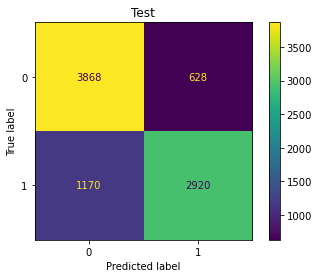

accuracy-score on test set :  0.7905893314698346
precision-score on test set :  0.8229988726042841
recall-score on test set :  0.7139364303178484
F1-score on test set :  0.7645980623199791


In [47]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_svm.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_svm.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_svm.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_svm.predict(x_test_vec)))

In [48]:
# SVM avec TfidfVectorizer

tv_svm = SVC()
tv_svm.fit(x_train_tfidf,y_train)

SVC()

In [49]:
# score train
tv_svm.score(x_train_tfidf,y_train)

0.989416404572912

In [50]:
# score test
tv_svm.score(x_test_tfidf,y_test)

0.7939669228977405

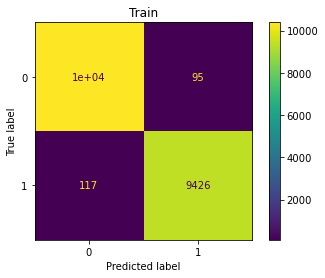

accuracy-score on train set :  0.989416404572912
precision-score on train set :  0.9900220565066694
recall-score on train set :  0.9877397044954417
F1-score on train set :  0.9888795635753251


In [51]:
#Matrice et score pour train avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_train_tfidf,y_train)
cm_tf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_svm.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_svm.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_svm.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_svm.predict(x_train_tfidf)))

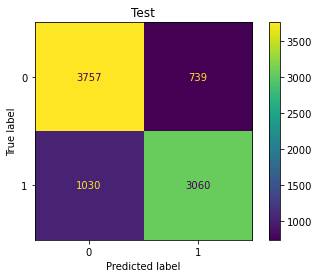

accuracy-score on test set :  0.7939669228977405
precision-score on test set :  0.8054751250329034
recall-score on test set :  0.7481662591687042
F1-score on test set :  0.7757637216377233


In [52]:
#Matrice et score pour test avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_test_tfidf,y_test)
cm_tf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_svm.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_svm.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_svm.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_svm.predict(x_test_tfidf)))

**Gradient Boosting Classifier**

In [53]:
#xgb = GradientBoostingClassifier()
#xgb.fit(x_train_vec,y_train)
#xgb.score(x_train_vec,y_train)
#xgb.score(x_test_vec,y_test)

In [54]:
# Gradient Boosting avec CountVectorizer

cv_gb = GradientBoostingClassifier()
cv_gb.fit(x_train_vec,y_train)

GradientBoostingClassifier()

In [55]:
# score train
cv_gb.score(x_train_vec,y_train)

0.6781488692526584

In [56]:
# score test
cv_gb.score(x_test_vec,y_test)

0.6673654786862334

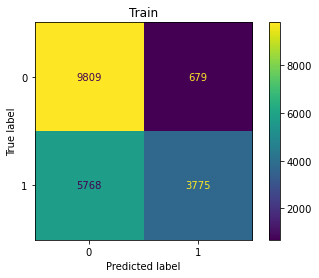

accuracy-score on train set :  0.6781488692526584
precision-score on train set :  0.8475527615626404
recall-score on train set :  0.3955779105103217
F1-score on train set :  0.5394013002786312


In [57]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_gb, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_gb.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_gb.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_gb.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_gb.predict(x_train_vec)))

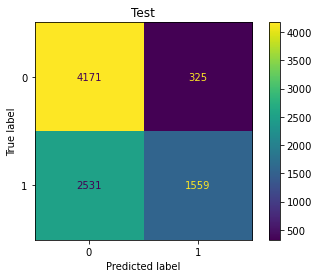

accuracy-score on test set :  0.6673654786862334
precision-score on test set :  0.8274946921443737
recall-score on test set :  0.38117359413202934
F1-score on test set :  0.5219283562102445


In [58]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_gb, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_gb.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_gb.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_gb.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_gb.predict(x_test_vec)))

In [59]:
# Gradient Boosting avec TfidfVectorizer

tv_gb = GradientBoostingClassifier()
tv_gb.fit(x_train_tfidf,y_train)

GradientBoostingClassifier()

In [60]:
# score train
tv_gb.score(x_train_tfidf,y_train)

0.6821426788477859

In [61]:
# score test
tv_gb.score(x_test_tfidf,y_test)

0.6722571628232006

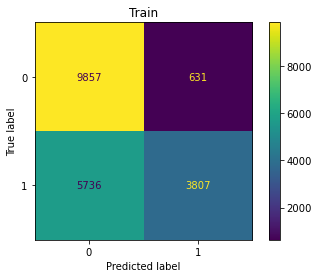

accuracy-score on train set :  0.6821426788477859
precision-score on train set :  0.8578188373141055
recall-score on train set :  0.3989311537252436
F1-score on train set :  0.5445962377512338


In [62]:
#Matrice et score pour train avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_gb, x_train_tfidf,y_train)
cm_tf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_gb.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_gb.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_gb.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_gb.predict(x_train_tfidf)))

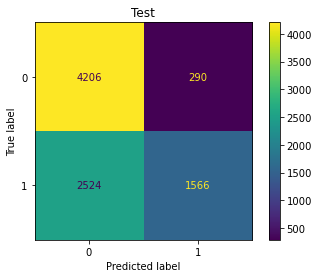

accuracy-score on test set :  0.6722571628232006
precision-score on test set :  0.84375
recall-score on test set :  0.3828850855745721
F1-score on test set :  0.5267406659939454


In [63]:
#Matrice et score pour test avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_gb, x_test_tfidf,y_test)
cm_tf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_gb.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_gb.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_gb.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_gb.predict(x_test_tfidf)))